In [8]:
import torch
from torch import nn as nn

import cv2 as cv
import mediapipe as mp

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from IPython.display import display, Image

from tqdm import tqdm
import os
import sys

import json
from glob import glob
from collections import OrderedDict


In [9]:
# This stops the absl logs in mediapipe from appearing in the markdown
sys.stderr = sys.__stderr__

In [10]:
import cv2
import mediapipe as mp

# Import the necessary drawing utilities and hands module from the MediaPipe library
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

def capture_image(camera):
    """
    This function opens the camera, displays the video feed, and captures an image when the 'c' key is pressed.
    It also uses the MediaPipe library to track the hand while the camera is open.

    Parameters:
    camera (cv2.VideoCapture): The camera object returned by cv2.VideoCapture(0).
    """


    # Initialize the Hands class from the MediaPipe library with a minimum detection confidence and tracking confidence
    with mp_hands.Hands(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as hands:

        while True:
            # Read a frame from the camera
            ret, frame = camera.read()
            if not ret:
                break

            # Convert the frame from BGR (OpenCV's default color format) to RGB (MediaPipe's required color format)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process the frame using the Hands class to detect and track the hand
            results = hands.process(frame)            

            # Convert the frame back to BGR for displaying with OpenCV
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            # If any hands are detected, draw the landmarks on the frame
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Display the frame in a window named 'Camera'
            cv2.imshow('Camera', frame)

            # Wait for a key press and check if it's the 'c' key
            key = cv2.waitKey(1) & 0xFF

            if key == ord('c'):
                # If the 'c' key is pressed, save the current frame as an image named 'captured_image.jpg'
                cv2.imwrite('captured_image.jpg', frame)
                print("Image captured!")
                break

    # Release the camera and close all OpenCV windows
    camera.release()
    cv2.destroyAllWindows()


# If this script is run directly (i.e., not imported), open the default camera (index 0) and call the capture_image function
if __name__ == '__main__':
    # sys.stdout = open(os.devnull, 'w')
    camera = cv2.VideoCapture(0)
    capture_image(camera)


    # sys.stdout = sys.__stdout__

In [11]:
def flatten_df(df):
    '''
    Auxillary function for process_image(). Takes in 21x3 pandas Dataframe and outputs a 1x63 Dataframe.
    '''

    # Initialize lists to hold new column names and values
    x_cols = [f'x{i}' for i in range(21)]
    y_cols = [f'y{i}' for i in range(21)]
    z_cols = [f'z{i}' for i in range(21)]

    # Extract coordinate columns and reshape
    x_values = df['x'].values
    y_values = df['y'].values
    z_values = df['z'].values

    # Create new DataFrame with reshaped data
    flattened_df = {
        **dict(zip(x_cols, x_values)),
        **dict(zip(y_cols, y_values)),
        **dict(zip(z_cols, z_values))
    }

    # Convert dictionary to DataFrame
    flattened_df = pd.DataFrame([flattened_df])

    return flattened_df

In [12]:
def draw_landmarks(image, landmarks):
    '''
    Auxillary function for process_image(). Creates a before and after picture showing hand landmarks drawn onto the original picture.
    '''
    
    # Draw the landmarks on the image
    image_with_landmarks = image.copy()
    mp_drawing.draw_landmarks(
        image_with_landmarks,
        landmarks,
        mp_hands.HAND_CONNECTIONS)

    # Display the original image and the image with the detected landmarks using a plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Image with Landmarks')
    axs[1].axis('off')
    plt.show()

In [82]:
import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

def process_image(image_path, show=False, label=True):
    """
    This function takes in an image, applies the MediaPipe hand model, and stores the landmark x, y, and z positions
    in a pandas DataFrame. It also displays the original image and the image with the detected landmarks drawn on it
    using a plot.

    Parameters:
    image_path (str): The path to the image file.
    show (bool): If true, displays the image before and after the mediapipe model is applied.

    Returns:
    pandas.DataFrame: A DataFrame containing the landmark x, y, and z positions.
    """

    # Load the image
    image = cv2.imread(image_path)


    # Initialize the Hands class from the MediaPipe library with a minimum detection confidence and tracking confidence
    with mp_hands.Hands(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as hands:

        # Convert the image from BGR (OpenCV's default color format) to RGB (MediaPipe's required color format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image using the Hands class to detect and track the hand
        results = hands.process(image_rgb)

        # If any hands are detected, extract the landmarks and draw them on the image
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0]

            # Create a list to store the landmark positions
            landmark_positions = []
            global t
            t = landmark_positions

            # Iterate over the landmarks and append their x, y, and z positions to the list
            for landmark in landmarks.landmark:
                landmark_positions.append([landmark.x, landmark.y, landmark.z])

            # Create a DataFrame from the landmark positions
            df = pd.DataFrame(landmark_positions, columns=['x', 'y', 'z'])

            # Flatten DataFrame
            df = flatten_df(df)

            # Adds a label to for the entry based off of the file it is located in. Also Shows full path.
            if label:
                df['label'] = image_path.split("/")[-2]
                df['path'] = image_path

            # Shows before and after picture showing hand landmarks drawn onto the original picture.
            if show:
                draw_landmarks(image, landmarks)

            # Converting df into dict
            df_dict = df.to_dict()

            return df_dict

        else:
            # print("\nNo hands detected in the image.")
            raise Exception("No hands detected in the image.")
            pass

In [94]:
print(np.array(t).T.flatten())

[ 4.64909405e-01  5.55219710e-01  6.11244321e-01  6.28574908e-01
  6.57870710e-01  5.59370160e-01  5.80614686e-01  5.69546461e-01
  5.57561815e-01  4.97236669e-01  5.20758331e-01  5.21486342e-01
  5.23056805e-01  4.39732999e-01  4.67841059e-01  4.80142593e-01
  4.88348424e-01  3.84107053e-01  4.20474648e-01  4.38464314e-01
  4.49238002e-01  7.08309531e-01  6.61323369e-01  5.56989431e-01
  4.74770188e-01  4.19055700e-01  4.78745818e-01  4.29304779e-01
  4.97439176e-01  5.53516626e-01  4.80177104e-01  4.38758880e-01
  5.23388624e-01  5.91302037e-01  4.90432948e-01  4.89201844e-01
  5.77232361e-01  6.36585951e-01  5.08372188e-01  5.17954290e-01
  5.82875013e-01  6.23481214e-01 -5.07543632e-07 -3.01217716e-02
 -3.71281989e-02 -4.52344008e-02 -4.70700227e-02 -9.29517020e-03
 -5.91462925e-02 -8.42653513e-02 -9.04539078e-02 -9.58090834e-03
 -7.03184307e-02 -8.48017856e-02 -7.59911686e-02 -1.82079934e-02
 -7.90610909e-02 -7.65591338e-02 -5.40409759e-02 -2.93586254e-02
 -6.89625517e-02 -6.77670

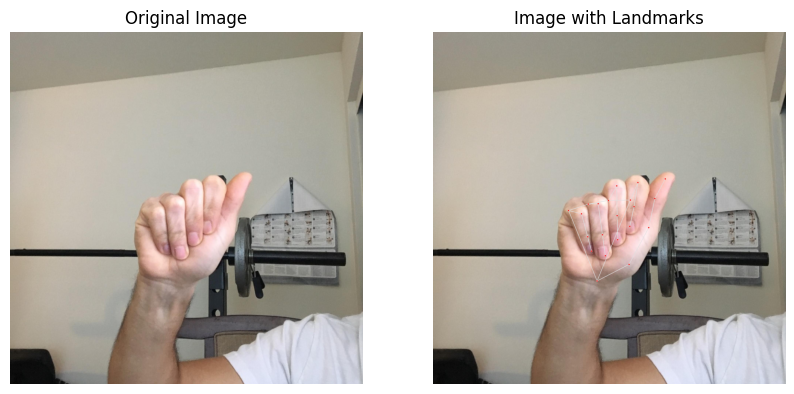

dict_values([{0: 0.4649094045162201}, {0: 0.5552197098731995}, {0: 0.6112443208694458}, {0: 0.6285749077796936}, {0: 0.6578707098960876}, {0: 0.5593701601028442}, {0: 0.5806146860122681}, {0: 0.5695464611053467}, {0: 0.5575618147850037}, {0: 0.4972366690635681}, {0: 0.520758330821991}, {0: 0.5214863419532776}, {0: 0.5230568051338196}, {0: 0.43973299860954285}, {0: 0.4678410589694977}, {0: 0.48014259338378906}, {0: 0.48834842443466187}, {0: 0.3841070532798767}, {0: 0.420474648475647}, {0: 0.43846431374549866}, {0: 0.44923800230026245}, {0: 0.708309531211853}, {0: 0.6613233685493469}, {0: 0.5569894313812256}, {0: 0.474770188331604}, {0: 0.419055700302124}, {0: 0.47874581813812256}, {0: 0.4293047785758972}, {0: 0.4974391758441925}, {0: 0.5535166263580322}, {0: 0.480177104473114}, {0: 0.43875887989997864}, {0: 0.5233886241912842}, {0: 0.5913020372390747}, {0: 0.4904329478740692}, {0: 0.4892018437385559}, {0: 0.5772323608398438}, {0: 0.6365859508514404}, {0: 0.5083721876144409}, {0: 0.51795

In [83]:
process_image('data/images/A/001.jpg', True).values()

In [49]:
# --- Main processing script ---
data_folder = 'data/images/*'
all_image_paths = sorted(glob(os.path.join(data_folder, '*')))

all_hand_landmarks = {}
processing_error_log = []

# Using tqdm to wrap the loop and create a progress bar
for image_path in tqdm(all_image_paths, desc="Processing Images", file=sys.stdout):
    try:
        
        # Call the process_image function and store the dict in output_dict
        output_dict = process_image(image_path)
        
        # Store the output dict in the all_hand_landmarks dictionary, using the image path as the key
        all_hand_landmarks[image_path] = output_dict
        
    except Exception as e:
        # print(f"Error processing {image_path}: {e}")
        processing_error_log.append(f"Error processing {image_path}: {e}")

# Save the all_hand_landmarks dictionary to a JSON file named "all_hand_landmarks.json"
with open("all_hand_landmarks.json", "w") as json_file:
    # sorted_landmarks = all_hand_landmarks.items()
    json.dump(all_hand_landmarks, json_file, indent=4)

DataFrame.from_dict()

print("All images processed and results saved to all_hand_landmarks.json")

# Logging errors in error_log.txt
with open("error_log.txt", 'w') as file:
    for errors in processing_error_log:
        file.write(errors + '\n')

print(f"{len(processing_error_log)} Errors Detected")


Processing Images: 100%|██████████| 1080/1080 [00:37<00:00, 29.05it/s]
All images processed and results saved to all_hand_landmarks.json
14 Errors Detected


In [73]:
df = process_image('data/images/A/001.jpg').drop(index=0)
df.loc[len(df)] = process_image('data/images/A/001.jpg')

ValueError: cannot set a row with mismatched columns

In [55]:
# --- Main processing script ---
data_folder = 'data/images/*'
all_image_paths = sorted(glob(os.path.join(data_folder, '*')))

all_hand_landmarks = {}
processing_error_log = []

# Using tqdm to wrap the loop and create a progress bar
for image_path in tqdm(all_image_paths, desc="Processing Images", file=sys.stdout):
    try:
        
        # Call the process_image function and store the dict in output_dict
        output_dict = process_image(image_path)
        
        # Store the output dict in the all_hand_landmarks dictionary, using the image path as the key
        all_hand_landmarks += output_dict
        
    except Exception as e:
        # print(f"Error processing {image_path}: {e}")
        processing_error_log.append(f"Error processing {image_path}: {e}")

# Save the all_hand_landmarks dictionary to a JSON file named "all_hand_landmarks.json"
with open("all_hand_landmarks.json", "w") as json_file:
    # sorted_landmarks = all_hand_landmarks.items()
    json.dump(all_hand_landmarks, json_file, indent=4)

print("All images processed and results saved to all_hand_landmarks.json")

# Logging errors in error_log.txt
with open("error_log.txt", 'w') as file:
    for errors in processing_error_log:
        file.write(errors + '\n')

print(f"{len(processing_error_log)} Errors Detected")

Processing Images: 100%|██████████| 1080/1080 [00:37<00:00, 29.12it/s]
All images processed and results saved to all_hand_landmarks.json
1080 Errors Detected


In [50]:
all_hand_landmarks

{'data/images/A/001.jpg': {'x0': {0: 0.4649094045162201},
  'x1': {0: 0.5552197098731995},
  'x2': {0: 0.6112443208694458},
  'x3': {0: 0.6285749077796936},
  'x4': {0: 0.6578707098960876},
  'x5': {0: 0.5593701601028442},
  'x6': {0: 0.5806146860122681},
  'x7': {0: 0.5695464611053467},
  'x8': {0: 0.5575618147850037},
  'x9': {0: 0.4972366690635681},
  'x10': {0: 0.520758330821991},
  'x11': {0: 0.5214863419532776},
  'x12': {0: 0.5230568051338196},
  'x13': {0: 0.43973299860954285},
  'x14': {0: 0.4678410589694977},
  'x15': {0: 0.48014259338378906},
  'x16': {0: 0.48834842443466187},
  'x17': {0: 0.3841070532798767},
  'x18': {0: 0.420474648475647},
  'x19': {0: 0.43846431374549866},
  'x20': {0: 0.44923800230026245},
  'y0': {0: 0.708309531211853},
  'y1': {0: 0.6613233685493469},
  'y2': {0: 0.5569894313812256},
  'y3': {0: 0.474770188331604},
  'y4': {0: 0.419055700302124},
  'y5': {0: 0.47874581813812256},
  'y6': {0: 0.4293047785758972},
  'y7': {0: 0.4974391758441925},
  'y8'